,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,159.3032,322388.5161,567.7927,0.7301,0.2395,0.1685
1,185.2165,154492.1309,393.0549,0.9145,0.2366,0.1800
2,112.7153,129841.0834,360.3347,0.7944,0.2816,0.2322
3,151.8713,93686.6630,306.0828,0.8480,0.8000,1.6739
4,184.4000,555215.8458,745.1281,0.7731,0.2344,0.1353
Mean,158.7013,251124.8478,474.4786,0.8120,0.3584,0.4780
Std,26.5526,171104.7989,161.2293,0.0638,0.2215,0.5988


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,112.1210,295204.7500,543.3275,0.7529,0.1670,0.1033
1,128.4463,95251.7686,308.6289,0.9473,0.1912,0.1351
2,56.4746,50319.9153,224.3210,0.9203,0.2126,0.1394
3,178.3652,158114.9913,397.6368,0.7435,0.8040,1.8190
4,91.4818,233426.9545,483.1428,0.9046,0.1323,0.0671
Mean,113.3778,166463.6759,391.4114,0.8537,0.3014,0.4528
Std,40.4213,89093.8317,115.1556,0.0873,0.2527,0.6836


Fitting 5 folds for each of 10 candidates, totalling 50 fits
           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     112.1210  295204.7500  543.3275  0.7529  0.1670  0.1033
1     128.4463   95251.7686  308.6289  0.9473  0.1912  0.1351
2      56.4746   50319.9153  224.3210  0.9203  0.2126  0.1394
3     178.3652  158114.9913  397.6368  0.7435  0.8040  1.8190
4      91.4818  233426.9545  483.1428  0.9046  0.1323  0.0671
Mean  113.3778  166463.6759  391.4114  0.8537  0.3014  0.4528
Std    40.4213   89093.8317  115.1556  0.0873  0.2527  0.6836


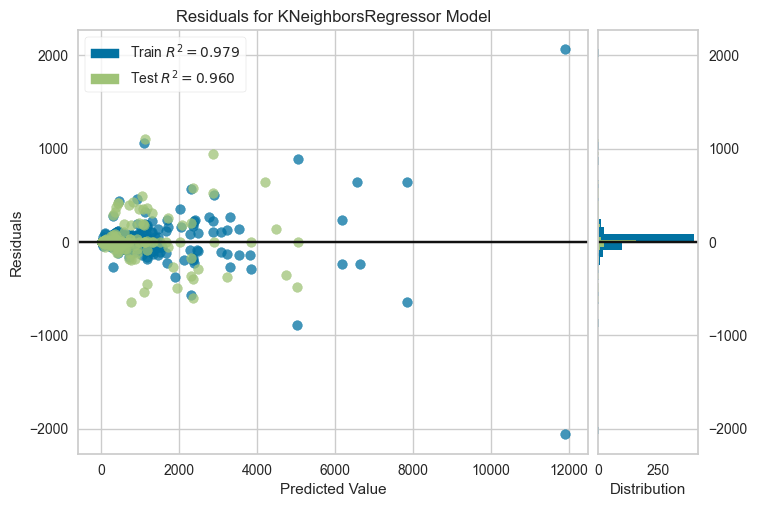

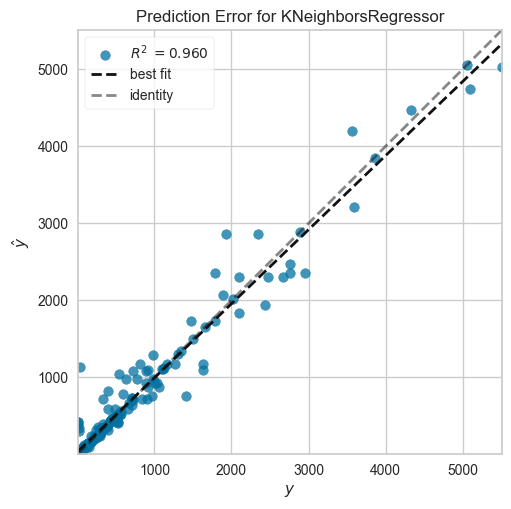

Transformation Pipeline and Model Successfully Saved


   temporada  anio        segmento Tipo_viajero  personas_pred
0    Navidad  2025       económico         Solo          439.0
1    Navidad  2025       económico       Pareja         1021.0
2    Navidad  2025       económico      Familia         1165.0
3    Navidad  2025       económico        Grupo          294.0
4    Navidad  2025  precio-calidad         Solo          439.0
5    Navidad  2025  precio-calidad       Pareja         1021.0
6    Navidad  2025  precio-calidad      Familia         1165.0
7    Navidad  2025  precio-calidad        Grupo          294.0
8    Navidad  2025         premium         Solo          224.0
9    Navidad  2025         premium       Pareja          513.0
10   Navidad  2025         premium      Familia          583.0
11   Navidad  2025         premium        Grupo          145.0


In [4]:
import pandas as pd
from pycaret.regression import *

# ---------- 1) Cargar y AGREGAR ----------
ruta = r"C:\Users\FABIO\Downloads\temporadas_SEG_TIPO_recalibrado_2020_2024_50k.csv"
df50 = pd.read_csv(ruta, encoding="utf-8-sig")

keys = ["temporada","anio","segmento","Tipo_viajero",
        "duracion_dias","mes_inicio","es_evento_ciudad","es_semana_santa","es_navidad","es_puente"]
train = (df50
         .groupby(keys, as_index=False)["personas"]
         .sum()
         .rename(columns={"personas":"personas_total"}))

# ---------- 2) Preprocesamiento ligero (evitar alta cardinalidad) ----------
# Une todos los 'Puente festivo X' en 'Puente festivo'
train["temporada"] = train["temporada"].str.replace(r"^Puente festivo.*", "Puente festivo", regex=True)

# Asegura tipos numéricos
num_cols = ["anio","duracion_dias","mes_inicio","es_evento_ciudad","es_semana_santa","es_navidad","es_puente","personas_total"]
train[num_cols] = train[num_cols].apply(pd.to_numeric, errors="coerce").fillna(0).astype(int)

# ---------- 3) PyCaret: setup para KNN (normalizado + GroupKFold por año) ----------
exp = setup(
    data=train.sort_values(["anio","temporada","segmento","Tipo_viajero"]),
    target="personas_total",
    fold=5, fold_strategy="groupkfold", fold_groups=train["anio"],
    normalize=True, normalize_method="zscore",
    categorical_features=["temporada","segmento","Tipo_viajero"],
    numeric_features=["anio","duracion_dias","mes_inicio",
                      "es_evento_ciudad","es_semana_santa","es_navidad","es_puente"],
    remove_multicollinearity=True, multicollinearity_threshold=0.95,
    session_id=42, verbose=False
)

# ---------- 4) Entrenar, afinar y guardar KNN ----------
knn   = create_model("knn")
t_knn = tune_model(knn, optimize="MAE")

print(pull().head(10))
plot_model(t_knn, plot="residuals")
plot_model(t_knn, plot="error")

final = finalize_model(t_knn)
save_model(final, "modelo_knn_temporadas_personas")

# ---------- 5) Ejemplo de predicción (Semana Santa 2025) ----------
rows = []
for seg in ["económico","precio-calidad","premium"]:
    for tip in ["Solo","Pareja","Familia","Grupo"]:
        rows.append({
            "temporada":"Navidad","anio":2025,"segmento":seg,"Tipo_viajero":tip,
            "duracion_dias":8,"mes_inicio":4,
            "es_evento_ciudad":0,"es_semana_santa":1,"es_navidad":0,"es_puente":0
        })
nuevas = pd.DataFrame(rows)
pred = predict_model(final, data=nuevas)
print(pred[["temporada","anio","segmento","Tipo_viajero","prediction_label"]]
      .rename(columns={"prediction_label":"personas_pred"}))


In [5]:
import joblib

# 'final' es el modelo ya finalizado (pipeline completa de PyCaret)
joblib.dump(final, r"C:\Users\FABIO\Downloads\modelo_knn_temporadas_personas.joblib")

# Verifica que carga OK
mdl = joblib.load(r"C:\Users\FABIO\Downloads\modelo_knn_temporadas_personas.joblib")

# Predice igual que con PyCaret:
# (pasa un DataFrame con las MISMAS columnas de entrenamiento)
import pandas as pd
test = pd.DataFrame([{
    "temporada":"Semana Santa","anio":2025,"segmento":"económico","Tipo_viajero":"Familia",
    "duracion_dias":8,"mes_inicio":4,
    "es_evento_ciudad":0,"es_semana_santa":1,"es_navidad":0,"es_puente":0
}])
yhat = mdl.predict(test)
print(yhat)

[2383.]
